# Viable traits

Compute the geographic habitat that is viable for each combination of traits within the [defined trait-space](trait-space-joint-pdf.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from itertools import product

import dask
import data_collections as dc
import funnel
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import regrid_tools
import util
import xarray as xr

/glade/work/mclong/miniconda3/envs/metabolic/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Ecotype viability

A region is considered habitable for a given organism if $\Phi > 1$ (for resting metabolism) or $\Phi > \Phi_{crit}$ (for active metabolism).

The Metabolic Index is a nonlinear function; therefore, the order of operations can have an impact on results. Acknowledging this subtlety, we choose to compute $\Phi$ on a monthly climatology of $P_{\mathrm{O}_2}$ and temperature and asses regions as habitable on the basis of the annual-mean value of $\Phi$. Here is that computation. 

### Compute monthly climatology
First step: spin up a `dask` cluster.

In [3]:
try:
    cluster
    client
except:
    cluster, client = util.get_ClusterClient(memory='100GB')
    cluster.scale(32)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.60:42378,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/asm/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


Load data from the CESM-LE and compute a monthly, ensemble-mean climatology.

In [4]:
sub_spec = dict(
    name='drift-corrected',
    experiment=['20C'],
    member_id=dc.ocean_bgc_member_ids,
    variable=['pO2', 'TEMP'],
)

catalog = funnel.to_intake_esm(agg_member_id=True).search(**sub_spec)

exp_keys = [
    f'20C.ocn.pop.h.drift-corrected',
]
dsets = catalog.to_dataset_dict()
assert set(dsets.keys()) == set(exp_keys)

_, ds = dsets.popitem()
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment.component.stream.name'


<xarray.Dataset>
Dimensions:     (member_id: 32, nlat: 384, nlon: 320, time: 1032, z_t: 40, d2: 2, z_t_150m: 15)
Coordinates:
  * member_id   (member_id) int64 2 9 10 11 12 13 14 ... 35 101 102 103 104 105
    KMT         (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA       (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    TLAT        (member_id, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    TLONG       (member_id, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ULAT        (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG       (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    dz          (z_t) float32 1e+03 1e+03 1e+03 ... 9.844e+03 1.133e+04
  * time        (time) object 1920-01-17 00:29:59.999993 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object 1920-01-02 00:59:59.999997 ... 2006-01-01 0...
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
  * z_t_150m    (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float64 dask.array<chunksize=(1, 12, 10, 384, 320), meta=np.ndarray>
    pO2         (member_id, time, z_t, nlat, nlon) float64 dask.array<chunksize=(1, 12, 10, 384, 320), meta=np.ndarray>
Attributes: (12/14)
    source:                    CCSM POP2, the CCSM Ocean Component
    tavg_sum:                  2592000.0
    intake_esm_varname:        TEMP\npO2
    nco_openmp_thread_number:  1
    tavg_sum_qflux:            2592000.0
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    ...                        ...
    calendar:                  All years have exactly  365 days.
    contents:                  Diagnostic and Prognostic Variables
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    history:                   none\nTue Sep 10 06:07:07 2013: /glade/apps/op...
    intake_esm_dataset_key:    20C.ocn.pop.h.drift-corrected

Choose a reference period corresponding to near-present and WOA2018 oxygen data compilation.

In [5]:
ds_clm = (
    ds.sel(time=slice("1960", "2017"))
    .mean("member_id")
    .groupby("time.month")
    .mean("time")
    .rename({"month": "time"})
    .compute()
)
ds_clm

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320, time: 12, z_t: 40, z_t_150m: 15)
Coordinates:
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    dz        (z_t) float32 1e+03 1e+03 1e+03 ... 8.521e+03 9.844e+03 1.133e+04
  * z_t       (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
  * z_t_150m  (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
  * time      (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    TEMP      (time, z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    pO2       (time, z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan

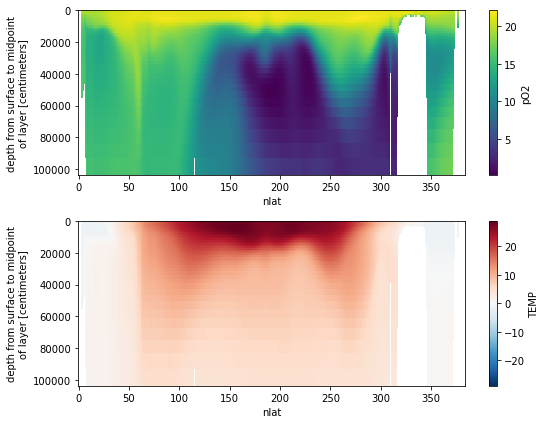

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
ds_clm.pO2.isel(nlon=200).mean('time').plot(yincrease=False, ax=axs[0])

ds_clm.TEMP.isel(nlon=200).mean('time').plot(yincrease=False, ax=axs[1])
plt.tight_layout();

In [7]:
ds_1x1 = regrid_tools.generate_latlon_grid(nx=360, ny=180, lon0=-180.0)[["area"]]
ds_1x1['z_t'] = ds.z_t
ds_1x1['dz'] = ds.dz

src_grid = regrid_tools.grid("POP_gx1v6")
dst_grid = regrid_tools.grid("latlon", nx=360, ny=180, lon0=-180.0)
regrid_obj = regrid_tools.regridder(src_grid, dst_grid, method="bilinear", clobber=False)
regrid_obj

exists: /glade/scratch/mclong/tmp/regridding/POP_gx1v6.nc
exists: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc
source grid dims: (384, 320)
destination grid dims: (180, 360)


regridder POP_gx1v6.nc --> latlon_1.0x1.0_lon0=-180.0.nc

In [8]:
ds_1x1 = xr.merge(
    (
        ds_1x1,
        regrid_obj(ds_clm[["TEMP", "pO2"]], renormalize=True, apply_mask=True).rename(
            {"nlat": "lat", "nlon": "lon"}
        ),
    )
)
ds_1x1

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, z_t: 40, time: 12)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    dz       (z_t) float32 1e+03 1e+03 1e+03 ... 8.521e+03 9.844e+03 1.133e+04
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 8.788e+04 9.847e+04
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    area     (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    TEMP     (time, z_t, lat, lon) float64 nan nan nan ... 0.6726 0.6725 0.6724
    pO2      (time, z_t, lat, lon) float64 nan nan nan nan ... 18.15 18.15 18.15

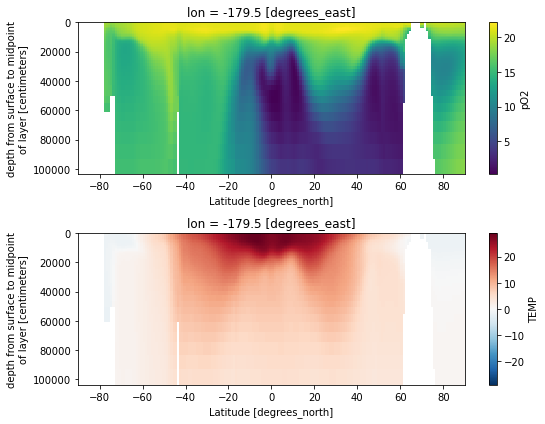

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6))
ds_1x1.pO2.isel(lon=0).mean('time').plot(yincrease=False, ax=axs[0])

ds_1x1.TEMP.isel(lon=0).mean('time').plot(yincrease=False, ax=axs[1])
plt.tight_layout();

### Compute viability 

First load trait space PDF.

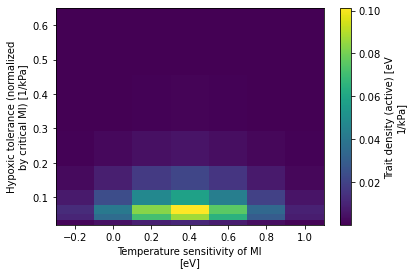

In [10]:
curator = util.curator_local_assets()
cat = curator.open_catalog()
ds_trait_space = cat['trait-space'].to_dask().load()

ds_trait_space.trait_spc_active.plot();

In [11]:
ds_trait_space.trait_spc_active

<xarray.DataArray 'trait_spc_active' (Ac: 8, Eo: 7)>
array([[1.34680503e-03, 4.47545908e-03, 9.02342586e-03, 1.10384049e-02,
        8.19298555e-03, 3.68959807e-03, 1.00813091e-03],
       [1.06140909e-02, 3.52708287e-02, 7.11130864e-02, 8.69930173e-02,
        6.45684353e-02, 2.90775046e-02, 7.94502019e-03],
       [1.23591079e-02, 4.10695540e-02, 8.28044832e-02, 1.01295165e-01,
        7.51838542e-02, 3.38580121e-02, 9.25122680e-03],
       [7.08526930e-03, 2.35444865e-02, 4.74704214e-02, 5.80708193e-02,
        4.31016426e-02, 1.94102305e-02, 5.30357316e-03],
       [2.56701395e-03, 8.53023685e-03, 1.71986736e-02, 2.10392290e-02,
        1.56158521e-02, 7.03238370e-03, 1.92150019e-03],
       [6.36403263e-04, 2.11478032e-03, 4.26382256e-03, 5.21595685e-03,
        3.87141615e-03, 1.74343888e-03, 4.76370216e-04],
       [1.11418788e-04, 3.70246781e-04, 7.46491996e-04, 9.13187634e-04,
        6.77791144e-04, 3.05233896e-04, 8.34008799e-05],
       [1.39113912e-05, 4.62278214e-05, 9.32045879e-05, 1.14017669e-04,
        8.46268206e-05, 3.81105218e-05, 1.04131654e-05]])
Coordinates:
  * Ac       (Ac) float64 0.0258 0.0399 0.0619 0.0959 ... 0.2303 0.3568 0.5528
  * Eo       (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
Attributes:
    N_traits:            56
    long_name:           Trait density (active)
    metabolic_baseline:  active
    units:               eV 1/kPa

Loop over trait space and store an index array into geographic space for each viable trait.

In [12]:
%%time
dpm = xr.DataArray(
    [31.0, 28.0, 31.0, 30.0, 31.0, 30.0, 31.0, 31.0, 30.0, 31.0, 30.0, 31.0],
    dims=("time"),
)

ds_clm_future = client.scatter(ds_1x1)


@dask.delayed
def Phi_mean(ds, Ac, Eo):
    return (dpm * mi.Phi(ds.pO2, ds.TEMP, Ac, Eo, dEodT=mi.dEodT_bar)).sum("time") / dpm.sum("time")


dso = xr.Dataset()
for v in ["trait_spc_active", "trait_spc_resting"]:

    # get trait space vars
    trait_space = ds_trait_space[v]
    hypoxic_tol, temp_sens = trait_space.dims

    Phi_varname = f'Phi_{ds_trait_space[v].metabolic_baseline}'
    viability_varname = f'viability_{ds_trait_space[v].metabolic_baseline}'

    ni = len(trait_space[hypoxic_tol])
    nj = len(trait_space[temp_sens])

    # loop over trait space and lat bands, sum trait frequency
    da_list_outer = []
    for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
        da_list_inner = []
        for j, Eo in enumerate(trait_space[temp_sens].values):
            da_list_inner.append(Phi_mean(ds_clm_future, A_parm, Eo))
        da_list_outer.append(da_list_inner)

    computed_list = dask.compute(*[obj for inner_list in da_list_outer for obj in inner_list])

    da_list_outer = []
    for i in range(ni):
        da_list_outer.append(
            xr.concat(computed_list[i * nj : i * nj + nj], dim=trait_space[temp_sens])
        )
    dso[Phi_varname] = xr.concat(da_list_outer, dim=trait_space[hypoxic_tol])
    dso[viability_varname] = xr.where((1 < dso[Phi_varname]) & (dso[Phi_varname] <= 2), 1.0, 0.0)
    dso[v] = ds_trait_space[v]
dso

CPU times: user 5.35 s, sys: 5.41 s, total: 10.8 s
Wall time: 28.2 s


<xarray.Dataset>
Dimensions:            (Ac: 8, Eo: 7, lat: 180, lon: 360, z_t: 40, Ao: 8)
Coordinates:
  * Ac                 (Ac) float64 0.0258 0.0399 0.0619 ... 0.3568 0.5528
  * Eo                 (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    dz                 (z_t) float32 1e+03 1e+03 1e+03 ... 9.844e+03 1.133e+04
  * z_t                (z_t) float32 500.0 1.5e+03 ... 8.788e+04 9.847e+04
  * Ao                 (Ao) float64 0.0613 0.0962 0.1508 ... 0.5813 0.9114 1.429
Data variables:
    Phi_active         (Ac, Eo, z_t, lat, lon) float64 0.0 0.0 ... 42.6 42.59
    viability_active   (Ac, Eo, z_t, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    trait_spc_active   (Ac, Eo) float64 0.001347 0.004475 ... 1.041e-05
    Phi_resting        (Ao, Eo, z_t, lat, lon) float64 0.0 0.0 ... 110.1 110.1
    viability_resting  (Ao, Eo, z_t, lat, lon) float64 0.0 0.0 0.0 ... 0.0 0.0
    trait_spc_resting  (Ao, Eo) float64 0.002386 0.007927 ... 0.000106 2.896e-05

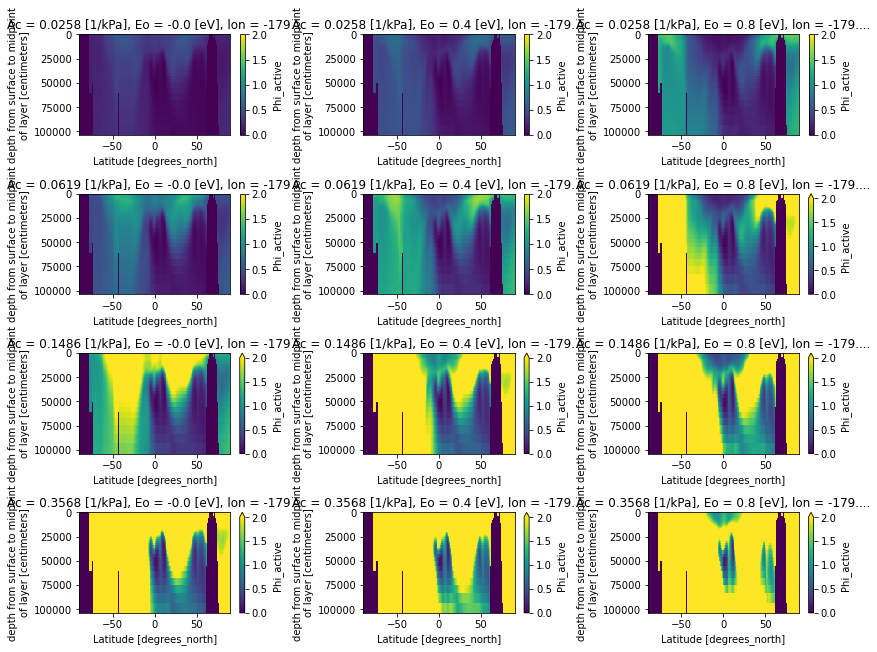

In [13]:
Eo = dso.Eo.values[1::2]  # [1, 3, 5]]
Ac = dso.Ac.values[::2]

fig, axs = plt.subplots(len(Ac), len(Eo), figsize=(12, 9))
for i, j in product(range(len(Ac)), range(len(Eo))):
    dso.Phi_active.sel(Eo=Eo[j], Ac=Ac[i]).isel(lon=0).plot(
        yincrease=False,
        ax=axs[i, j],
        vmin=0,
        vmax=2,
    )

plt.tight_layout();

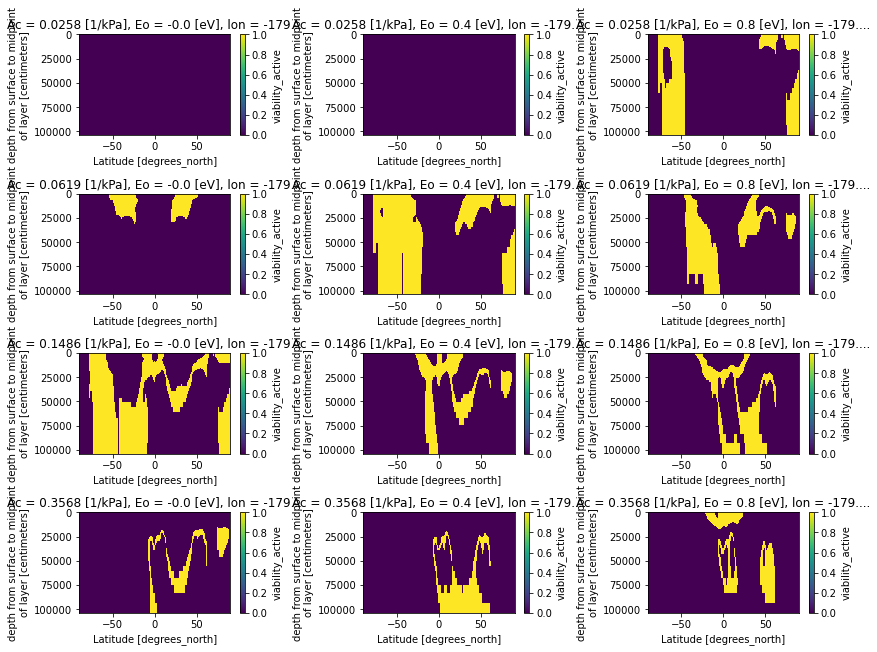

In [14]:
Eo = dso.Eo.values[1::2]  # [1, 3, 5]]
Ac = dso.Ac.values[::2]

fig, axs = plt.subplots(len(Ac), len(Eo), figsize=(12, 9))
for i, j in product(range(len(Ac)), range(len(Eo))):
    dso.viability_active.sel(Eo=Eo[j], Ac=Ac[i]).isel(lon=0).plot(
        yincrease=False,
        ax=axs[i, j],
        vmin=0,
        vmax=1,
    )

plt.tight_layout();

## Write a cache file

In [15]:
clobber = True

this_notebook = 'compute-viable-traits.ipynb'

curator = util.curator_local_assets()

key = 'viable-traits-mask-cesm-1x1'
if clobber:
    cache_file = f'{dc.cache_dir}/{key}.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    dso.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key=key,
        urlpath=cache_file,
        description=f'Viable traits mask generated by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )

overwriting "viable-traits-mask-cesm-1x1" key in "sources"


In [16]:
if True:
    cluster.close()
    client.close()